# Github Source
https://gist.github.com/mahmoodm2/519099b45e31f1bce159a6a13e44e1d0

In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras import layers
from IPython import display

## Data Exploration

In [4]:
def getAllImages(path):

    files = []

    for folder in os.listdir(path):

        if "." not in folder: 

            for image in os.listdir(path + folder):

                img = path + folder + "/" + image

                files.append(img)

    return files

In [5]:
benign_path = 'D:/Medical_Imaging_Projekt/Dataset/benign/'
malignant_path = 'D:/Medical_Imaging_Projekt/Dataset/malignant/'

In [6]:
files_benign = getAllImages(benign_path)
print("Sample size of benign images:", len(files_benign))


files_malignant = getAllImages(malignant_path)
print("Sample size of malignant images:", len(files_malignant))

Sample size of benign images: 625
Sample size of malignant images: 1370


In [7]:
def showSamples(files, name):

    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    for ax in axes:

        idx = np.random.randint(0, len(files))
        
        filename = files[idx]

        img = mpimg.imread(filename)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Breast Cancer Histopathological {} Image with size: {}'.format(name, img.shape))

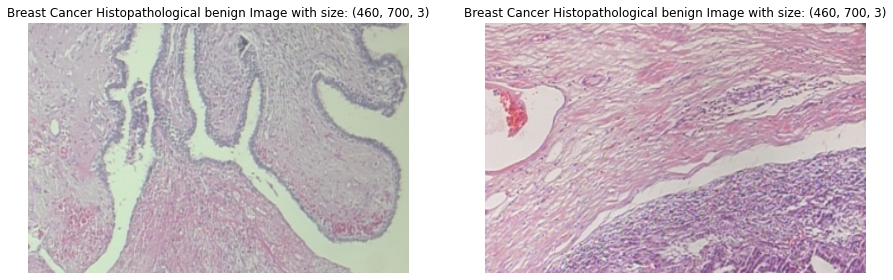

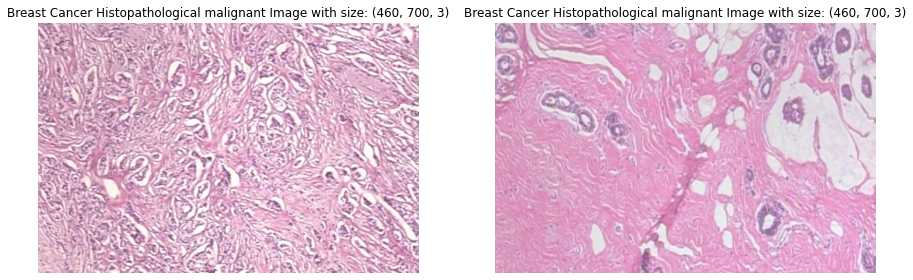

In [8]:
showSamples(files_benign, 'benign')
showSamples(files_malignant, 'malignant')

## Data Processing

In [9]:
# files = [*files_benign, *files_malignant]
files = [*files_benign]
print(len(files))

625


In [13]:
# read images and provide a consitent size of 64 by 64 pixels
def reformatSizeImage(filename):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels = 1)
    image_resized = tf.image.resize(image_decoded, [256, 256])

    return image_resized

In [14]:
# normalize images
def normalizeImages(image):

    image = (image - 127.5) / 127.5
    
    return image

In [15]:
random.shuffle(files)

dataset = tf.data.Dataset.from_tensor_slices((files))

dataset = dataset.shuffle(10000)

dataset = dataset.map(reformatSizeImage, num_parallel_calls = 16)

train_images = dataset.map(normalizeImages, num_parallel_calls = 16)

In [16]:
BUFFER_SIZE = 625
BATCH_SIZE = 256

In [18]:
train_dataset = train_images.batch(BATCH_SIZE)

## GAN Architecture

### Generator

In [23]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 1)

    return model

In [24]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

AssertionError: 

### Discriminator

In [74]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [75]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00210757]], shape=(1, 1), dtype=float32)


### Optimizers and losses

In [76]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [77]:
def discriminator_loss(real_output, fake_output):

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss
     

In [78]:
def generator_loss(fake_output):
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [79]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [80]:
checkpoint_dir = './GAN_Imags/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define training loop

In [81]:
EPOCHS = 2 #50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [82]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [83]:
def generate_and_save_images(model, epoch, test_input, imsave_dir):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(os.path.join(imsave_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

In [84]:
def train(dataset, epochs):

  for epoch in range(epochs):

    start = time.time()

    for image_batch in dataset:
      
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Model Training

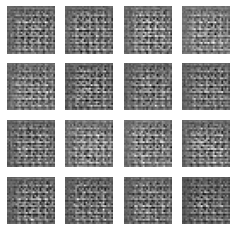

In [85]:
train(train_dataset, EPOCHS)

In [86]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))